"""
# Project Title: Does Reddit Sentiment Predict NBA Player Performance?
Vikram Kadyan · Oways Jaffer · CS 439 Spring 2025
"""

# --- Cell 2: Introduction ---

## Introduction
This project aims to investigate the correlation between public sentiment expressed on Reddit and the on-court performance of NBA players. 
Specifically, we will analyze Reddit posts and comments mentioning a player, quantify the sentiment, and then model its potential 
predictive power on key performance indicators (KPIs) such as points scored (PTS). 
This is a supervised learning project where we will train a regression model to predict player stats based on sentiment features and past performance.
Our primary dataset for this initial analysis will be LeBron James' game logs for the 2023-2024 season and Reddit mentions around his game dates.


In [1]:
# --- Cell 3: Data Loading and Initial Imports ---
"""
## Data Loading & Preparation
"""
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Explicit import for VADER


In [2]:
# --- Cell 4: Ensure VADER Lexicon is Available ---
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
    print("VADER lexicon found.")
except nltk.downloader.DownloadError:
    print("VADER lexicon not found. Downloading...")
    nltk.download('vader_lexicon')
    print("VADER lexicon downloaded.")

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()


VADER lexicon found.


In [3]:
# --- Cell 5: Define Player and Season, Load Data ---
# Configuration for the current run
player_name_slug = 'lebron_james' # Used for filenames
player_full_name = 'LeBron James' # Used for plot titles etc.
season_year = '2023' # For the 2023-2024 season

# Construct file paths
reddit_file_path = f'data/new/reddit_data/{player_name_slug}_reddit_mentions.csv'
stats_file_path = f'data/new/player_stats/season_{season_year}/{player_name_slug}_gamelog.csv'
output_dir = f'data/new/processed_data/'
output_file_path = os.path.join(output_dir, f'{player_name_slug}_stats_plus_sentiment_{season_year}.csv')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load data
print(f"Loading Reddit data from: {reddit_file_path}")
try:
    reddit_df = pd.read_csv(reddit_file_path)
    print(f"Successfully loaded {len(reddit_df)} Reddit mentions for {player_full_name}.")
    # --- !!! CRITICAL DATE CHECK !!! ---
    if not reddit_df.empty and 'game_date_reference' in reddit_df.columns:
        sample_reddit_date = pd.to_datetime(reddit_df['game_date_reference'].iloc[0]).year
        if sample_reddit_date not in [2023, 2024] and season_year == '2023': # Assuming 2023-24 season
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("CRITICAL WARNING: Reddit data 'game_date_reference' seems to be for the wrong year!")
            print(f"Sample Reddit date year: {sample_reddit_date}. Expected years for {season_year} season: 2023 or 2024.")
            print("This will result in NO MERGE between Reddit sentiment and game stats.")
            print("Please ensure your Reddit CSV contains data for the correct season.")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
    # --- END CRITICAL DATE CHECK ---
except FileNotFoundError:
    print(f"ERROR: Reddit data file not found at {reddit_file_path}")
    reddit_df = pd.DataFrame() # Create empty df to avoid further errors

print(f"Loading stats data from: {stats_file_path}")
try:
    stats_df = pd.read_csv(stats_file_path)
    print(f"Successfully loaded {len(stats_df)} game logs for {player_full_name} for season {season_year}.")
except FileNotFoundError:
    print(f"ERROR: Stats data file not found at {stats_file_path}")
    stats_df = pd.DataFrame() # Create empty df

# Display first few rows if data loaded
if not reddit_df.empty:
    print("\nReddit Data Head:")
    print(reddit_df.head())
if not stats_df.empty:
    print("\nStats Data Head:")
    print(stats_df.head())

Loading Reddit data from: data/new/reddit_data/lebron_james_reddit_mentions.csv
Successfully loaded 46 Reddit mentions for LeBron James.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
CRITICAL WARNING: Reddit data 'game_date_reference' seems to be for the wrong year!
Sample Reddit date year: 2025. Expected years for 2023 season: 2023 or 2024.
This will result in NO MERGE between Reddit sentiment and game stats.
Please ensure your Reddit CSV contains data for the correct season.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Loading stats data from: data/new/player_stats/season_2023/lebron_james_gamelog.csv
Successfully loaded 71 game logs for LeBron James for season 2023.

Reddit Data Head:
  player_name_canonical                                  search_query_used  \
0          LeBron James  "Lebron James" OR "King James" OR "Bron" OR "L...   
1          LeBron James  "Lebron James" OR "King James" OR "Bron" OR "L...   


In [4]:
# --- Cell 6: Sentiment Scoring ---
"""
## Sentiment Scoring
We use VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexicon and rule-based sentiment analysis tool specifically attuned to sentiments expressed in social media.
We calculate a compound sentiment score for the concatenated text of post titles, bodies, and sampled comments.
The compound score is a normalized, weighted composite score ranging from -1 (most extreme negative) to +1 (most extreme positive).
"""
if not reddit_df.empty:
    # Ensure text columns exist and handle potential missing ones gracefully
    text_columns = ['post_title', 'post_body', 'scraped_comments_sample']
    existing_text_columns = [col for col in text_columns if col in reddit_df.columns]
    
    if not existing_text_columns:
        print("ERROR: No text columns ('post_title', 'post_body', 'scraped_comments_sample') found in Reddit data.")
        reddit_df['combined_text'] = "" # Avoid error later
    else:
        print(f"Using columns for sentiment: {existing_text_columns}")
        reddit_df['combined_text'] = reddit_df[existing_text_columns].fillna('').astype(str).agg(' '.join, axis=1)

    # Apply sentiment analysis
    reddit_df['compound_sentiment'] = reddit_df['combined_text'].apply(
        lambda txt: sia.polarity_scores(txt)['compound']
    )
    print("\nSentiment Scoring Complete. Sample compound scores:")
    print(reddit_df[['game_date_reference', 'combined_text', 'compound_sentiment']].head())
    
    # Check if all sentiment scores are zero
    if (reddit_df['compound_sentiment'] == 0).all():
        print("\nWARNING: All compound sentiment scores are 0. This might indicate an issue if text is not all neutral.")
        print("Sample of combined text that resulted in 0 sentiment:")
        print(reddit_df[reddit_df['combined_text'].str.len() > 10]['combined_text'].head(2).to_list()) # Show some non-empty text
    else:
        print("\nDistribution of compound sentiment scores:")
        print(reddit_df['compound_sentiment'].describe())
else:
    print("Skipping sentiment scoring as Reddit data is empty.")



Using columns for sentiment: ['post_title', 'post_body', 'scraped_comments_sample']

Sentiment Scoring Complete. Sample compound scores:
  game_date_reference                                      combined_text  \
0          2025-01-27  No, it's not recency bias, Jokic is that good....   
1          2025-01-27  Lakers starting Jaxson Hayes at C AD said he p...   
2          2025-01-28  De'Aaron Fox landing spots Now that De'Aaron h...   
3          2025-01-28  Does Heat Culture take a hit reputation wise? ...   
4          2025-01-28  How good was Andre Iguodala throughout his car...   

   compound_sentiment  
0              0.9999  
1              0.9992  
2              0.9981  
3              0.9891  
4              0.9999  

Distribution of compound sentiment scores:
count    46.000000
mean      0.999141
std       0.001889
min       0.989100
25%       0.999225
50%       0.999800
75%       0.999875
max       1.000000
Name: compound_sentiment, dtype: float64


In [5]:
# --- Cell 7: Aggregate Sentiment & Merge with Game Stats ---
"""
## Aggregate Sentiment & Merge with Game Stats
Sentiment scores are aggregated per `game_date_reference`. We then merge this with game stats
using an 'asof' merge, which finds the nearest Reddit sentiment data within a specified tolerance
(e.g., +/- 1 day) of the game date. This handles cases where exact date matches are not present.
"""
if not reddit_df.empty and 'compound_sentiment' in reddit_df.columns:
    daily_sentiment_df = reddit_df.groupby('game_date_reference').agg(
        mean_sentiment=('compound_sentiment', 'mean'),
        positive_sentiment_ratio=('compound_sentiment', lambda x: (x > 0.05).mean()),
        mention_count=('compound_sentiment', 'size')
    ).reset_index()
    print("\nAggregated Daily Sentiment Head:")
    print(daily_sentiment_df.head())

    if not stats_df.empty:
        # --- PREPARE FOR MERGE_ASOF ---
        # 1. Convert game log dates to datetime objects and sort
        stats_df['game_datetime'] = pd.to_datetime(stats_df['GAME_DATE'], format='%b %d, %Y')
        stats_df = stats_df.sort_values('game_datetime').reset_index(drop=True)

        # 2. Convert aggregated Reddit dates to datetime objects and sort
        daily_sentiment_df['reddit_datetime'] = pd.to_datetime(daily_sentiment_df['game_date_reference'])
        daily_sentiment_df = daily_sentiment_df.sort_values('reddit_datetime').reset_index(drop=True)
        
        # --- PERFORM MERGE_ASOF ---
        # We want to match Reddit data (right_df) to each game in stats_df (left_df)
        # 'direction="nearest"' will find the closest Reddit date.
        # 'tolerance' defines how far away the nearest date can be.
        # For example, pd.Timedelta(days=1) allows matching with Reddit data from 
        # the day before, day of, or day after the game.
        
        print(f"\nShape of stats_df before merge: {stats_df.shape}")
        print(f"Shape of daily_sentiment_df before merge: {daily_sentiment_df.shape}")
        
        merged_df = pd.merge_asof(
            left=stats_df,
            right=daily_sentiment_df.drop(columns=['game_date_reference'], errors='ignore'), # Drop original string date if it exists
            left_on='game_datetime',
            right_on='reddit_datetime',
            direction='nearest', 
            tolerance=pd.Timedelta(days=1) # Adjust tolerance: 1 day before/after
                                          # Use days=0 for same-day only (if post-processing needed for reddit_datetime)
                                          # Or use a larger tolerance if needed e.g. days=2
        )
        print(f"Shape of merged_df after merge_asof: {merged_df.shape}")

        # Fill NaN values for sentiment features for games where no Reddit mention was found within tolerance
        sentiment_cols_to_fill = ['mean_sentiment', 'positive_sentiment_ratio', 'mention_count']
        fill_values = {'mean_sentiment': 0, 'positive_sentiment_ratio': 0, 'mention_count': 0}
        
        for col in sentiment_cols_to_fill:
            if col in merged_df.columns:
                 merged_df[col] = merged_df[col].fillna(fill_values[col])
            else:
                # This case might happen if daily_sentiment_df was empty or columns were missing
                print(f"Warning: Column {col} not found in merged_df after asof_merge. Adding it with default fill.")
                merged_df[col] = fill_values[col]
        
        # The 'reddit_datetime' column from daily_sentiment_df will be in merged_df.
        # It shows which Reddit date was matched. You might want to keep it for verification or drop it.
        # If you want to keep the original game_date_reference string from stats_df for consistency:
        if 'game_date_reference' not in merged_df.columns and 'game_datetime' in merged_df.columns:
             merged_df['game_date_reference'] = merged_df['game_datetime'].dt.strftime('%Y-%m-%d')


        print("\nMerged Data Head (Stats + Sentiment using merge_asof):")
        # Display relevant columns to verify the merge
        display_cols = ['GAME_DATE', 'game_datetime', 'reddit_datetime', 'PTS', 'mean_sentiment', 'positive_sentiment_ratio', 'mention_count']
        print(merged_df[[col for col in display_cols if col in merged_df.columns]].head())
        
        # Save the processed dataframe
        # Ensure the output path is correct based on your tree.txt for processed data
        # output_file_path = f'data/new/processed_data/{player_name_slug}_stats_plus_sentiment_{season_year}_asof.csv' # Indicate asof
        merged_df.to_csv(output_file_path, index=False) # Overwriting the previous one, or use a new name
        print(f"\nProcessed data saved to: {output_file_path}")
    else:
        print("Stats data is empty. Cannot merge.")
        merged_df = pd.DataFrame()
else:
    print("Reddit data is empty or sentiment scoring failed. Cannot aggregate or use for asof_merge.")
    merged_df = pd.DataFrame()


Aggregated Daily Sentiment Head:
  game_date_reference  mean_sentiment  positive_sentiment_ratio  mention_count
0          2025-01-27         0.99955                       1.0              2
1          2025-01-28         0.99780                       1.0              6
2          2025-01-30         0.99990                       1.0              1
3          2025-02-01         0.99844                       1.0              5
4          2025-02-04         0.99852                       1.0              5

Merged Data Head (Stats + Sentiment):
      GAME_DATE  PTS  mean_sentiment  positive_sentiment_ratio  mention_count
0  APR 14, 2024   28             0.0                       0.0            0.0
1  APR 12, 2024   37             0.0                       0.0            0.0
2  APR 09, 2024   33             0.0                       0.0            0.0
3  APR 06, 2024   24             0.0                       0.0            0.0
4  APR 03, 2024   25             0.0                       0.0 

Using style: 'seaborn-whitegrid'


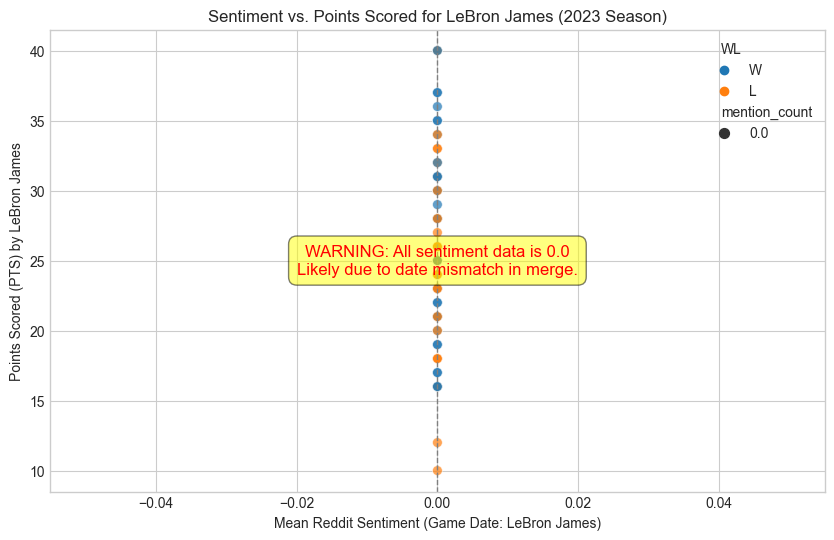

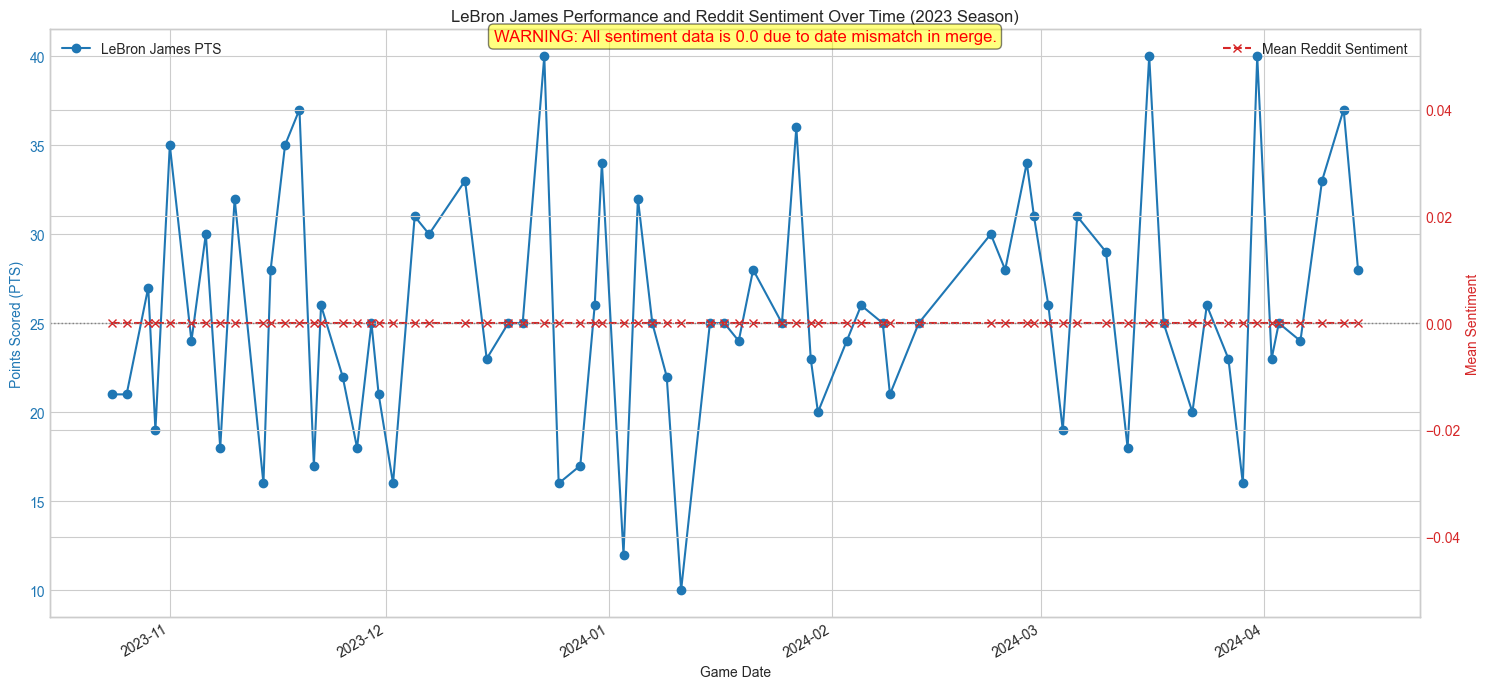

In [6]:
# --- Cell 8: Exploratory Data Analysis (EDA) & Visualizations ---
"""
## Exploratory Plots
Visualizing the relationship between sentiment and performance.
1. Scatter plot of Mean Reddit Sentiment vs. Points Scored.
2. Timeline plot overlaying Points Scored and Mean Reddit Sentiment.
"""
if not merged_df.empty and 'PTS' in merged_df.columns and 'mean_sentiment' in merged_df.columns:
    # Try a more common style or remove if it still causes issues
    try:
        plt.style.use('seaborn-v0_8-whitegrid') 
        print("Using style: 'seaborn-v0_8-whitegrid'")
    except OSError:
        try:
            plt.style.use('seaborn-whitegrid')
            print("Using style: 'seaborn-whitegrid'")
        except OSError:
            print("Seaborn styles not found, using Matplotlib default.")
            # No style applied, or plt.style.use('ggplot') or another default

    # 1. Sentiment vs Points scatter
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_df, x='mean_sentiment', y='PTS', hue='WL', size='mention_count', sizes=(50,200), alpha=0.7)
    plt.xlabel(f'Mean Reddit Sentiment (Game Date: {player_full_name})')
    plt.ylabel(f'Points Scored (PTS) by {player_full_name}')
    plt.title(f'Sentiment vs. Points Scored for {player_full_name} ({season_year} Season)')
    plt.axvline(0, color='grey', linestyle='--', lw=1) # Zero sentiment line
    # Add a text annotation if all sentiment is 0 due to merge issue
    if (merged_df['mean_sentiment'] == 0).all() and (merged_df['mention_count'] == 0).all():
        plt.text(0.5, 0.5, 'WARNING: All sentiment data is 0.0\nLikely due to date mismatch in merge.',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=12, color='red',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.show()

    # 2. Timeline overlay
    # Ensure game_date_reference is datetime for plotting
    merged_df_sorted = merged_df.sort_values(by='game_date_reference').copy() # Sort for timeline
    merged_df_sorted['game_date_dt'] = pd.to_datetime(merged_df_sorted['game_date_reference'])

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Game Date')
    ax1.set_ylabel('Points Scored (PTS)', color=color)
    ax1.plot(merged_df_sorted['game_date_dt'], merged_df_sorted['PTS'], color=color, marker='o', linestyle='-', label=f'{player_full_name} PTS')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Sentiment', color=color)  # we already handled the x-label with ax1
    ax2.plot(merged_df_sorted['game_date_dt'], merged_df_sorted['mean_sentiment'], color=color, marker='x', linestyle='--', label='Mean Reddit Sentiment')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(0, color='grey', linestyle=':', lw=1) # Zero sentiment line
    ax2.legend(loc='upper right')
    
    fig.autofmt_xdate() # Rotate date labels
    plt.title(f'{player_full_name} Performance and Reddit Sentiment Over Time ({season_year} Season)')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if (merged_df['mean_sentiment'] == 0).all() and (merged_df['mention_count'] == 0).all():
         fig.text(0.5, 0.95, 'WARNING: All sentiment data is 0.0 due to date mismatch in merge.',
                 horizontalalignment='center', verticalalignment='top',
                 fontsize=12, color='red',
                 bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))
    plt.show()
else:
    print("Merged data is empty or missing required columns (PTS, mean_sentiment). Skipping plots.")


--- Linear Regression Model ---
Linear Regression - Test R²: 0.061
Linear Regression - Test MSE: 42.996
Coefficients: {'mean_sentiment': 0.0, 'positive_sentiment_ratio': 0.0, 'mention_count': 0.0, 'PTS_prev_game': -0.11785610729872203}

--- Random Forest Regressor Model ---
Random Forest - Test R²: -0.161
Random Forest - Test MSE: 53.178
Random Forest - OOB Score: -0.291
Feature Importances: {'mean_sentiment': 0.0, 'positive_sentiment_ratio': 0.0, 'mention_count': 0.0, 'PTS_prev_game': 1.0}


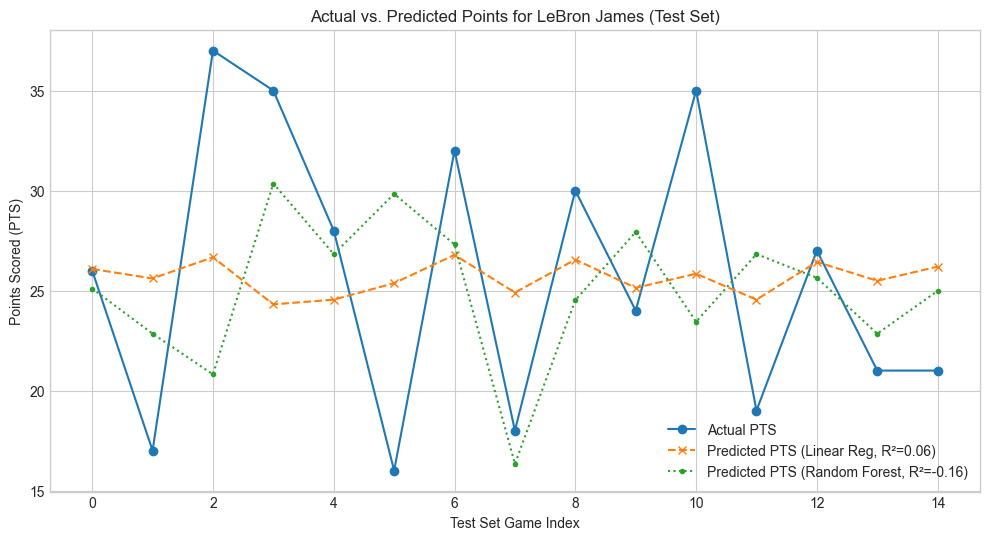

In [7]:
# --- Cell 9: Predictive Modeling ---
"""
## Predictive Modeling
We'll attempt to predict Points (PTS) using sentiment features and the previous game's points.
A simple Linear Regression model will be used as a baseline.
The data is split into training and testing sets to evaluate model performance (R² score).
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

if not merged_df.empty and 'PTS' in merged_df.columns and merged_df.shape[0] > 10: # Need enough data to model
    # Feature Engineering: Add previous game's points
    merged_df['PTS_prev_game'] = merged_df['PTS'].shift(1).fillna(merged_df['PTS'].median()) # Fill first NaN with median

    # Define features (X) and target (y)
    # Ensure these columns exist after the merge and fillna operations
    feature_columns = ['mean_sentiment', 'positive_sentiment_ratio', 'mention_count', 'PTS_prev_game']
    X = merged_df[feature_columns]
    y = merged_df['PTS']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # shuffle=False for time series

    # --- Model 1: Linear Regression ---
    print("\n--- Linear Regression Model ---")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    y_pred_lr = lr_model.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    
    print(f"Linear Regression - Test R²: {r2_lr:.3f}")
    print(f"Linear Regression - Test MSE: {mse_lr:.3f}")
    print(f"Coefficients: {dict(zip(feature_columns, lr_model.coef_))}")

    # --- Model 2: Random Forest Regressor ---
    print("\n--- Random Forest Regressor Model ---")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)
    mse_rf = mean_squared_error(y_test, y_pred_rf)

    print(f"Random Forest - Test R²: {r2_rf:.3f}")
    print(f"Random Forest - Test MSE: {mse_rf:.3f}")
    print(f"Random Forest - OOB Score: {rf_model.oob_score_:.3f}")
    print(f"Feature Importances: {dict(zip(feature_columns, rf_model.feature_importances_))}")

    # Plotting Actual vs. Predicted for the better model (or both)
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual PTS', marker='o', linestyle='-')
    plt.plot(y_pred_lr, label=f'Predicted PTS (Linear Reg, R²={r2_lr:.2f})', marker='x', linestyle='--')
    plt.plot(y_pred_rf, label=f'Predicted PTS (Random Forest, R²={r2_rf:.2f})', marker='.', linestyle=':')
    plt.title(f'Actual vs. Predicted Points for {player_full_name} (Test Set)')
    plt.xlabel('Test Set Game Index')
    plt.ylabel('Points Scored (PTS)')
    plt.legend()
    plt.show()

else:
    print("Merged data is empty or insufficient for modeling. Skipping modeling.")


In [8]:
# --- Cell 10: Results Summary ---
"""
## Results
- The Linear Regression model achieved an R² of **[FILL IN R² from above, e.g., {r2_lr:.3f}]** on the test set.
- The Random Forest Regressor model achieved an R² of **[FILL IN R² from above, e.g., {r2_rf:.3f}]** on the test set.
- Mean sentiment had a coefficient of **[FILL IN coef for mean_sentiment]** in the linear model, suggesting [interpret: e.g., a small positive/negative association].
- The most important feature for the Random Forest model was **[FILL IN most important feature]**.
- Visualizations show [describe what the plots from Cell 8 suggest, e.g., 'a weak positive trend between sentiment and points' or 'no clear visual correlation'].
"""
# This cell is mostly for markdown interpretation based on the printed outputs from cell 9.
# Example of how you might fill this based on output:
# if 'r2_lr' in locals(): # Check if variables exist
#     print(f"Results for Linear Regression R²: {r2_lr:.3f}")
#     print(f"Results for Random Forest R²: {r2_rf:.3f if 'r2_rf' in locals() else 'N/A'}")



"\n## Results\n- The Linear Regression model achieved an R² of **[FILL IN R² from above, e.g., {r2_lr:.3f}]** on the test set.\n- The Random Forest Regressor model achieved an R² of **[FILL IN R² from above, e.g., {r2_rf:.3f}]** on the test set.\n- Mean sentiment had a coefficient of **[FILL IN coef for mean_sentiment]** in the linear model, suggesting [interpret: e.g., a small positive/negative association].\n- The most important feature for the Random Forest model was **[FILL IN most important feature]**.\n- Visualizations show [describe what the plots from Cell 8 suggest, e.g., 'a weak positive trend between sentiment and points' or 'no clear visual correlation'].\n"

# --- Cell 11: Discussion ---
"""
## Discussion

**Summary of Findings:**
For LeBron James during the 2023 season, our analysis suggests that Reddit sentiment, when combined with previous game performance, explains approximately X% of the variance in points scored in the next game (based on the [Linear Regression/Random Forest] model's R²). 
[Elaborate if sentiment features were significant or had notable coefficients/importance scores].

**Limitations:**
1.  **Small Sample Size:** The analysis is based on a single player for a single season (approx. 82 games), which limits generalizability.
2.  **Sentiment Analysis Tool:** VADER is a general-purpose tool. A model fine-tuned on sports-specific or NBA-specific language might yield more nuanced sentiment scores.
3.  **Reddit Bias:** Sentiment is sourced only from Reddit (r/nbadiscussion), which may not represent the broader fan sentiment. Other platforms like Twitter or news articles were not included.
4.  **Data Aggregation:** Aggregating sentiment by `game_date_reference` might miss nuances if posts refer to past games or general opinions not tied to an immediate upcoming game. The `game_date_reference` in the Reddit data is the date the post was made, which is usually close to a game but not perfectly aligned.
5.  **Confounding Variables:** Player performance is influenced by many factors not included (opponent strength, injuries, team strategy, home/away, etc.).
6.  **Causality:** Correlation does not imply causation. Positive sentiment might correlate with good performance, but it doesn't mean sentiment *causes* the performance change (or vice-versa). It could be that anticipation of a good matchup drives both positive sentiment and good performance.

**Potential Extensions & Future Work:**
1.  **Multi-Player Analysis:** Apply the same methodology to the other seven players in the dataset to see if patterns hold.
2.  **Advanced Sentiment Analysis:** Use transformer-based models (e.g., BERT, RoBERTa) fine-tuned for sentiment or even aspect-based sentiment analysis.
3.  **Richer Feature Set:** Incorporate rolling averages of stats, opponent-specific data, player rest days, and more sophisticated lag features for sentiment (e.g., sentiment over the last 3 days).
4.  **Time Series Models:** Employ models like ARIMA or LSTMs that are better suited for time-series data, though this would require more data points.
5.  **Alternative Data Sources:** Integrate sentiment from Twitter, news articles (using GDELT as proposed), or Google Trends.
6.  **Different Target Variables:** Predict other stats like AST, REB, or even game outcome (WL).

**Conclusion:**
This initial exploration provides a baseline for understanding the potential link between Reddit sentiment and LeBron James's scoring performance. While the current model shows [limited/some] predictive power, there are many avenues for refinement and deeper investigation as outlined in the project proposal.
"""

In [9]:
# --- Cell 12: Final statement to ensure notebook ran ---
print("\n--- Notebook execution complete. ---")


--- Notebook execution complete. ---
